In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill 
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="6">    <b>Probability over time</b>

Now we will attempt to fix this thing:
    
    - Extract the epoch and the data on which we will train then test the classifier
    - Extract the features on all the epochs and data of interest
    - Train the LDA with 70% of the features
    - Test the LDA with the other 30%

In [2]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\chans_rp-win_-1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None)
velocity = pd.read_csv(pathm, header=None)

pathemg = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/7/\emg.csv'
emg = pd.read_csv(pathemg, header=None)

np.save('eeg_7', eeg)
np.save('velocity_7', velocity)
np.save('emg_7', emg)

In [3]:
eeg = np.load('eeg_7.npy')
velocity = np.load('velocity_7.npy')
emg_7 = np.load('emg_7.npy')
emg = emg_7[:,:]

In [4]:
# EEG channel selection
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg[i,:])
eeg_b = np.asarray(eeg_b)


# Baseline corection
emg[1,:] = emg[1,:] - emg[1,0]
emg[0,:] = emg[0,:] - emg[0,0]


<font size="3">    <b>Velocity: Extraction of area of interest</b>

In [5]:
# The first and last onsets do not have enough samples before or after to get a proper frame extraction.
fs = 250

before = (fs * 2) +1
after  =  fs

velo   = np.zeros((len(move), (before + after)))

for k in range(len(move)):
    
        velo[k, :(before + after)] = velocity[0, move[k] - before : move[k] + after]

<font size="3" color='blue'>    <b>EMG: Epochs extraction and extraction of area of interest</b>

In [6]:
# Number of sample before and after movement onset
idleb_emg   = fs * 6
idlea_emg   = fs * (-5)

intentb_emg = fs
intenta_emg = 0

interb_emg  = fs * 3     # ALWAYS TAKE 250 SAMPLES MORE BEFORE THE DESIRED START
intera_emg  = fs * 1

# Let's create matrices with row = epoch, columns = epoch duration and 3D = nb_chan
idle_emg    = np.zeros((len(move), (idleb_emg + idlea_emg),    emg.shape[0]))      # Idle period
intent_emg  = np.zeros((len(move), (intentb_emg + intenta_emg),emg.shape[0]))      # Intention period
inter_emg   = np.zeros((len(move), (interb_emg + intera_emg),  emg.shape[0]))      # Period of interest

for k in range(len(move)):
   
    for j in range(emg.shape[0]):
    
        idle_emg[k, 0:(idleb_emg + idlea_emg), j]       = emg[j, move[k] - idleb_emg : move[k] + idlea_emg]
        intent_emg[k, 0:(intentb_emg + intenta_emg), j] = emg[j, move[k] - intentb_emg : move[k] + intenta_emg]
        inter_emg[k, 0:(interb_emg + intera_emg), j]    = emg[j, move[k] - interb_emg : move[k] + intera_emg]

In [7]:
emg

array([[ 0.00000000e+00, -5.84631925e-06, -7.72747444e-06, ...,
        -4.54743608e-03, -4.53213282e-03, -4.51999955e-03],
       [ 0.00000000e+00, -5.40167094e-08,  1.96136534e-06, ...,
         1.57494284e-03,  1.53911859e-03,  1.51031092e-03]])

In [8]:
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

feat_list = [rms, mini, maxi, mav, var]

<font size="3" color='blue'>    <b>Extract the features for idle and intent</b>
    
10 features per onset.

In [9]:
win = 250
sld_size = 1

feat_idle   = np.zeros((len(move), emg.shape[0]*len(feat_list)))
feat_intent = np.zeros((len(move), emg.shape[0]*len(feat_list)))                  

for k in range(len(move)):              # Index of the onset
   
    for j in range(emg.shape[0]):    # Index of the channel
        
        for i in range(len(feat_list)): # Index of the feature
        
            feat_idle[k, i +(5*j)]   = np.apply_along_axis(feat_list[i], 0, idle_emg[k, :, j])
            feat_intent[k, i +(5*j)] = np.apply_along_axis(feat_list[i], 0, intent_emg[k, :, j])

<font size="3" color='blue'>    <b>Extract the features on period of interest with a sliding window</b>

In [10]:
feat_inter = np.zeros((len(move), emg.shape[0]*len(feat_list), (inter_emg.shape[1]//sld_size) - fs + sld_size))

for k in range(len(move)):                  # Index of the onset
    
    for l in range(feat_inter.shape[2]):    # Index of the slide
   
        for j in range(emg.shape[0]):    # Index of the channel
        
            for i in range(len(feat_list)): # Index of the feature
        
                feat_inter[k, i +(5*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                 inter_emg[k, (sld_size*l):win+(sld_size*l), j])
        

<font size="3" color='blue'>    <b>DataFrame and LDA training</b>

In [11]:
test   = 105
idle_emg   = pd.concat([pd.DataFrame(feat_idle), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent_emg = pd.concat([pd.DataFrame(feat_intent), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_emg_train = pd.concat([idle_emg.iloc[:test,:], intent_emg.iloc[:test,:]], axis=0) # Only train on 110 first epochs

In [13]:
Xemg = df_emg_train.iloc[:, :10].values
yemg = df_emg_train.iloc[:, 10].values

clf_emg = LDA(solver='lsqr', shrinkage='auto')

clf_emg.fit(Xemg, yemg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_emg, Xemg, yemg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.7285714285714285
0.10869249724298406


<font size="3" color='blue'>    <b>Probability extraction</b>

In [14]:
proba_emg = np.zeros((len(move)-test, feat_inter.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter.shape[2]):
        
        proba_emg[k, l] = clf_emg.predict_proba(feat_inter[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='blue'>    <b>DataFrame including Time, Velocity and Proba</b>

In [33]:
time = np.arange(-2-1/fs, 1, 1/fs)                        # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_emg = np.reshape(proba_emg, len(f_time))

m_velo = velo[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_emg = np.zeros((len(f_time), 3))
f_data_emg[:,0] = f_time
f_data_emg[:,1] = f_velocity * 1000
f_data_emg[:,2] = f_proba_emg
final_emg = pd.DataFrame(f_data_emg, columns=['Time', 'Velocity', 'Probability'])
final_emg

,Time,Velocity,Probability
0,-2.004,0.007360,0.110579
1,-2.000,0.008037,0.110449
2,-1.996,0.008699,0.110316
3,-1.992,0.009091,0.110182
4,-1.988,0.009416,0.110049
...,...,...,...
56320,0.980,1.154001,0.835597
56321,0.984,1.145557,0.835287
56322,0.988,1.137358,0.834971
56323,0.992,1.129639,0.834653


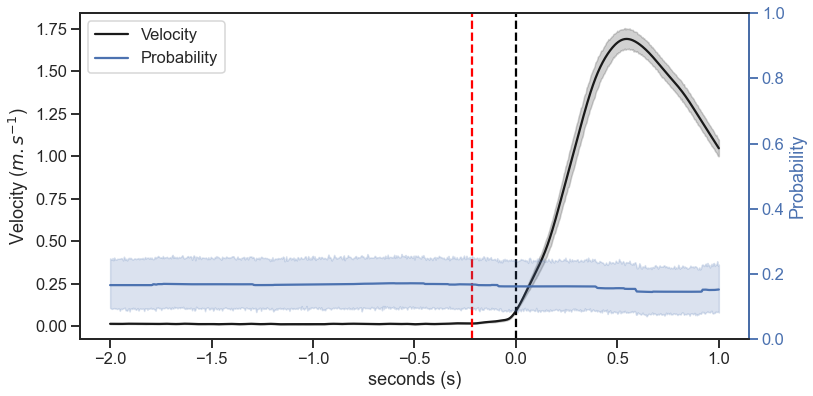

In [16]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(-0.216,
            color='red', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=final_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='Probability')])

<font size="3" color='red'>    <b>EEG: Epochs extraction and extraction of area of interest</b>

In [17]:
# Number of sample before and after movement onset
idleb_eeg   = fs * 6
idlea_eeg   = fs * (-5)

intentb_eeg = fs
intenta_eeg = 0

interb_eeg  = fs * 3
intera_eeg  = fs * 1

# Let's create matrices with row = epoch, columns = epoch duration and 3D = nb_chan
idle_eeg    = np.zeros((len(move), (idleb_eeg + idlea_eeg),    eeg_b.shape[0]))      # Idle period
intent_eeg  = np.zeros((len(move), (intentb_eeg + intenta_eeg),eeg_b.shape[0]))      # Intention period
inter_eeg   = np.zeros((len(move), (interb_eeg + intera_eeg),  eeg_b.shape[0]))      # Period of interest

for k in range(len(move)):
   
    for j in range(eeg_b.shape[0]):
    
        idle_eeg[k, 0:(idleb_eeg + idlea_eeg), j]       = eeg_b[j, move[k] - idleb_eeg : move[k] + idlea_eeg]
        intent_eeg[k, 0:(intentb_eeg + intenta_eeg), j] = eeg_b[j, move[k] - intentb_eeg : move[k] + intenta_eeg]
        inter_eeg[k, 0:(interb_eeg + intera_eeg), j]    = eeg_b[j, move[k] - interb_eeg : move[k] + intera_eeg]

<font size="3" color='red'>    <b>Feature extration on idle and intent</b>

In [19]:
win       = 250
sld_size  = 1
feat_size = 25
n_feat    = win//feat_size

feat_idle_eeg   = np.zeros((len(move), eeg_b.shape[0]*n_feat))
feat_intent_eeg = np.zeros((len(move), eeg_b.shape[0]*n_feat))                  

for k in range(len(move)):              # Index of the onset
   
    for j in range(eeg_b.shape[0]):     # Index of the channel
        
        for i in range(n_feat):         # Index of the feature
        
            feat_idle_eeg[k, i +(n_feat*j)]   = np.mean(idle_eeg[k, (feat_size*i):feat_size + (feat_size*i), j])
            feat_intent_eeg[k, i +(n_feat*j)] = np.mean(intent_eeg[k, (feat_size*i):feat_size + (feat_size*i), j])

<font size="3" color='red'>    <b>Feature extraction on area on interest with sliding window</b>

In [20]:
feat_inter_eeg = np.zeros((len(move), eeg_b.shape[0]*n_feat, (inter_eeg.shape[1]//sld_size) - fs + sld_size))

for k in range(len(move)):                   # Index of the onset
    
    for l in range(feat_inter_eeg.shape[2]): # Index of the slide
   
        for j in range(eeg_b.shape[0]):      # Index of the channel
            
            for i in range(n_feat):          # Index of the feature
        
                feat_inter_eeg[k, i +(n_feat*j), l] = np.mean(inter_eeg[k, 
                                                  (feat_size*i)+(sld_size*l):feat_size + 
                                                  (feat_size*i)+(sld_size*l), j])


<font size="3" color='red'>    <b>Baseline correction CHECK THIS AGAIN WITH FRESH BRAIN</b>

In [21]:
#Correct the baseline after mean feature extraction, I think it should work that way
idle_cor   = np.zeros((feat_idle_eeg.shape))
intent_cor = np.zeros((feat_intent_eeg.shape))
inter_cor  = np.zeros((feat_inter_eeg.shape))

for k in range(len(move)):
    
    for j in range(eeg_b.shape[0]):
    
        idle_cor[k, (10*j):10+(10*j)]   = feat_idle_eeg[k, (10*j):10+(10*j)] - idle_eeg[k, 0, j]
        intent_cor[k, (10*j):10+(10*j)] = feat_intent_eeg[k, (10*j):10+(10*j)] - intent_eeg[k, 0, j]
            
        for l in range(feat_inter_eeg.shape[2]):
            
            inter_cor[k, (10*j):10+(10*j), l] = feat_inter_eeg[k, (10*j):10+(10*j), l] - inter_eeg[k, l, j]
        

<font size="3" color='red'>    <b>DataFrames</b>

In [22]:
test   = 105
idle_eeg   = pd.concat([pd.DataFrame(idle_cor), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent_eeg = pd.concat([pd.DataFrame(intent_cor), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_eeg_train = pd.concat([idle_eeg.iloc[:test,:], intent_eeg.iloc[:test,:]], axis=0) 

In [32]:
df_eeg_train

class                                                        \
          0         1          2          3          4          5     
0    3.163138  3.714662   9.724008   8.806944   9.025626  13.657559   
1   -5.983634 -9.801904  -4.459620  -0.941402 -13.554268 -13.213821   
2    8.684118  3.956762   9.317783  15.535073   8.160369   3.269273   
3   -1.516552 -9.222898 -16.662050 -10.198722  -7.734352  -6.877583   
4    7.214118  0.532912   6.345493   6.190864   5.002257   2.153669   
..        ...       ...        ...        ...        ...        ...   
100  2.607886  7.215587   8.753467  11.242834  19.390275  18.884860   
101  3.399868  5.614978  -3.978430  -2.038741  -8.855536  -4.314398   
102  9.266038  2.926330   0.203512  -4.557571  -7.698371 -13.430347   
103  4.768673  6.407981  10.341772  13.724076  20.346647  23.449473   
104  1.981910  2.281287   0.104836   1.170676   6.061752  -1.851395   

                                                 ...                        \
           6          7          8          9    ...        191        192   
0    11.079720   5.517949   6.870684  14.448675  ...   5.910658   8.744005   
1    -7.846404  -6.818379  -8.178888  -1.447094  ...  -2.045904   2.484380   
2     4.612542  -0.220306  -3.224362  10.516840  ...  -2.611238  -5.858216   
3    -4.050353  -5.789944  -5.346318  -0.672989  ...  -3.226897  -1.990048   
4    21.193010  18.078116   8.101871   1.857752  ...  14.584913  14.933494   
..         ...        ...        ...        ...  ...        ...        ...   
100  21.268731  20.190694  18.884962  16.135823  ...   0.635587  -1.578534   
101 -16.622431 -11.105874 -15.720894 -22.734363  ...  -1.681023  -5.402431   
102 -12.201568 -17.658586 -17.142648 -19.513340  ...  -1.861670  -5.460488   
103  23.448807  25.491459  27.998901  27.435949  ...   1.123980   6.801772   
104  -0.652712  -5.833156  -2.492778 -17.070073  ...  -3.470711  -2.367162   

                                                                       \
           193        194        195        196        197        198   
0     8.490941  16.933623  14.481555  12.891717  10.885946  13.890680   
1     0.410598   2.033732   3.186179   2.565596  -1.650378  -3.546888   
2    -2.344926  -2.439630  -6.958726 -12.051457  -7.836305  -6.640361   
3     1.857280   0.201651   2.598419   2.017648   6.958057  11.877684   
4    16.502865  14.054258  10.757670  13.417011  16.634117  19.113871   
..         ...        ...        ...        ...        ...        ...   
100   6.498834  11.398275  12.976859  10.728730  13.298694  17.956961   
101 -10.694742 -19.151537 -16.322399 -20.190432 -20.901874 -17.628895   
102  -7.485571  -8.250371 -11.358347 -17.785568 -17.666586 -21.286649   
103  11.040075  18.350646  26.369472  29.164806  28.803458  35.042900   
104  -0.993322  -0.126247  -1.695394  -1.364711  -2.097154   2.059223   

               features  
           199      0    
0     9.136672      0.0  
1    -2.491094      0.0  
2    -7.339160      0.0  
3     8.707012      0.0  
4    20.961752      0.0  
..         ...      ...  
100  19.667823      1.0  
101 -19.666363      1.0  
102 -20.793339      1.0  
103  30.171948      1.0  
104  -2.054071      1.0  

[210 rows x 201 columns]

<font size="3" color='red'>    <b>Classifier training</b>

In [23]:
Xeeg = df_eeg_train.iloc[:, :-1].values
yeeg = df_eeg_train.iloc[:, -1].values

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.780952380952381
0.07126966450997982


<font size="3" color='red'>    <b>Probability testing</b>

In [24]:
proba_eeg = np.zeros((len(move)-test, feat_inter_eeg.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter_eeg.shape[2]):
        
        proba_eeg[k, l] = clf_eeg.predict_proba(inter_cor[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>DataFrame, Velocity, Proba</b>

In [25]:
time = np.arange(-2-1/fs, 1, 1/fs)                        # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg = np.reshape(proba_eeg, len(f_time))

m_velo = velo[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_eeg = np.zeros((len(f_time), 3))
f_data_eeg[:,0] = f_time
f_data_eeg[:,1] = f_velocity * 1000
f_data_eeg[:,2] = f_proba_eeg
final_eeg = pd.DataFrame(f_data_eeg, columns=['Time', 'Velocity', 'Probability'])
final_eeg

,Time,Velocity,Probability
0,-2.000,0.007360,0.074464
1,-1.996,0.008037,0.234350
2,-1.992,0.008699,0.145740
3,-1.988,0.009091,0.179138
4,-1.984,0.009416,0.183790
...,...,...,...
56320,0.984,1.154001,0.061101
56321,0.988,1.145557,0.157811
56322,0.992,1.137358,0.266996
56323,0.996,1.129639,0.190650


<font size="3" color='red'>    <b>Plot</b>

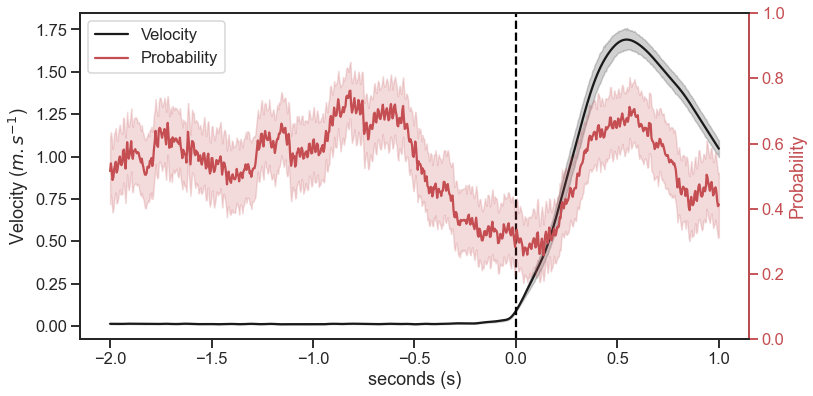

In [26]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final_eeg, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

<font size="3" color='purple'>    <b>Merge for EEG_EMG</b>

In [27]:
idle_eeg_emg   = np.concatenate((feat_idle, idle_cor), axis=1)
intent_eeg_emg = np.concatenate((feat_intent, intent_cor), axis=1)

inter_eeg_emg  = np.concatenate((feat_inter, inter_cor), axis=1)

test   = 105
idle   = pd.concat([pd.DataFrame(idle_eeg_emg), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent = pd.concat([pd.DataFrame(intent_eeg_emg), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_eeg_emg_train = pd.concat([idle.iloc[:test,:], intent.iloc[:test,:]], axis=0) 

<font size="3" color='purple'>    <b>Classifier</b>

In [28]:
Xeeg_emg = df_eeg_emg_train.iloc[:, :-1].values
yeeg_emg = df_eeg_emg_train.iloc[:, -1].values

clf_eeg_emg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg_emg.fit(Xeeg_emg, yeeg_emg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg_emg, Xeeg_emg, yeeg_emg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.7857142857142857
0.0775181933147605


<font size="3" color='purple'>    <b>Proba</b>

In [29]:
proba_eeg_emg = np.zeros((len(move)-test, feat_inter_eeg.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter_eeg.shape[2]):
        
        proba_eeg_emg[k, l] = clf_eeg_emg.predict_proba(inter_eeg_emg[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='purple'>    <b>DataFrame</b>

In [30]:
time = np.arange(-2, 1+1/fs, 1/fs)                       # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg_emg = np.reshape(proba_eeg_emg, len(f_time))

m_velo = velo[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_eeg_emg = np.zeros((len(f_time), 3))
f_data_eeg_emg[:,0] = f_time
f_data_eeg_emg[:,1] = f_velocity * 1000
f_data_eeg_emg[:,2] = f_proba_eeg_emg
final_eeg_emg = pd.DataFrame(f_data_eeg_emg, columns=['Time', 'Velocity', 'Probability'])
final_eeg_emg

,Time,Velocity,Probability
0,-2.000,0.007360,0.016879
1,-1.996,0.008037,0.051914
2,-1.992,0.008699,0.027013
3,-1.988,0.009091,0.034779
4,-1.984,0.009416,0.041321
...,...,...,...
56320,0.984,1.154001,0.633830
56321,0.988,1.145557,0.782399
56322,0.992,1.137358,0.877619
56323,0.996,1.129639,0.817731


<font size="3" color='purple'>    <b>Plot</b>

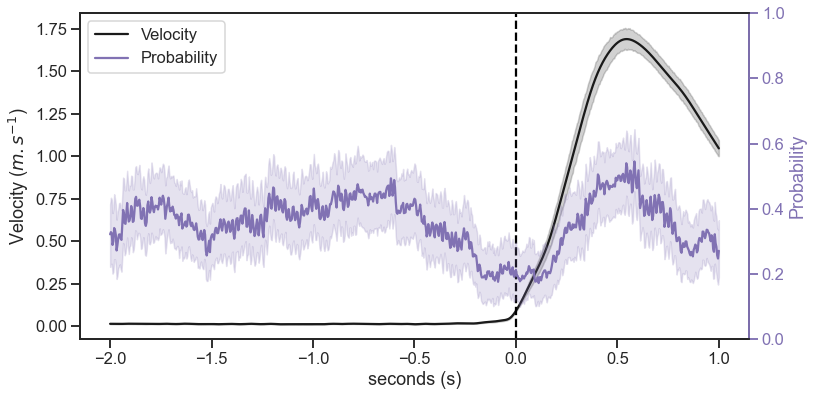

In [31]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='m')
ax2.spines['right'].set_color('m')
ax2.tick_params(axis='y', colors='m')
ep_prob = sns.lineplot(data=final_eeg_emg, x='Time', y='Probability', ax=ax2, color='m', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="m", label='Probability')])